In [7]:
# import gymnasium as gym
import gym
import numpy as np
import random
from matplotlib import pyplot as plt
import torch
from torch import Tensor
from torch.autograd import Variable
import copy
from collections import deque
from IPython.display import clear_output

In [2]:
def plot_res(values, title=''):
    clear_output(wait=True)
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red', ls='--', label='goal')
    ax[0].axhline(np.mean(values[-100:]), c='blue', ls='--')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x, p(x), "--", label='trend')
    except:
        pass
    ax[1].hist(values[-50:])
    # ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    # ax[1].legend()
    plt.show()

In [8]:
# AGENT/NETWORK HYPERPARAMETERS
EPSILON_INITIAL = 0.5 # exploration rate
EPSILON_DECAY = 0.99
EPSILON_MIN = 0.01
ALPHA = 0.001 # learning rate
GAMMA = 0.99 # discount factor
TAU = 0.1 # target network soft update hyperparameter
EXPERIENCE_REPLAY_BATCH_SIZE = 32
AGENT_MEMORY_LIMIT = 2000
MIN_MEMORY_FOR_EXPERIENCE_REPLAY = 500
env = gym.make('CartPole-v1')

c:\Users\aaron\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\aaron\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [9]:
class DQN():
    def __init__(self):
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(env.observation_space.shape[0], 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, env.action_space.n)
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(), ALPHA)
        self.epsilon = EPSILON_INITIAL
        self.memory = deque(maxlen=AGENT_MEMORY_LIMIT)
        # self.memory = []

    def update(self, state, y):
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def act(self, state):
        if self.epsilon > np.random.rand():
            return env.action_space.sample()
        else:
            return torch.argmax(self.model(torch.Tensor(state))).item()

    def experience_replay(self):
        if len(self.memory) > MIN_MEMORY_FOR_EXPERIENCE_REPLAY:
            batch = random.sample(self.memory, EXPERIENCE_REPLAY_BATCH_SIZE)
            batch_t = list(map(list, zip(*batch))) #Transpose batch list
            states,actions,next_states,rewards,is_dones = batch_t
            states = np.array(states)
            next_states = np.array(next_states)
            rewards = Tensor(rewards)
            states = Tensor(states)
            next_states = Tensor(next_states)
            is_dones_tensor = Tensor(is_dones)


            # predicted q_values of all states
            all_q_values = self.model(states)
            all_q_values_next = self.model(next_states)
            # Update q values
            all_q_values[range(len(all_q_values)), actions] = rewards + \
                GAMMA*torch.max(all_q_values_next, axis=1).values * (1-is_dones_tensor)
            self.update(states.tolist(), all_q_values.tolist())

    def remember(self, state, action, next_state, reward, done):
        if len(self.memory) <= AGENT_MEMORY_LIMIT:
            experience = (state, action, next_state, reward, done)
            self.memory.append(experience)

    def update_epsilon(self):
        self.epsilon = max(self.epsilon * EPSILON_DECAY, EPSILON_MIN)


MAX_TRAINING_EPISODES = 200


agent = DQN()
env.seed(1)
trial_episode_scores = []

for episode_index in range(MAX_TRAINING_EPISODES):
    state, _ = env.reset()
    episode_score = 0

    done = truncated = False
    while not (done | truncated):
        action = agent.act(state)
        next_state, reward, done, truncated, _ = env.step(action)
        episode_score += reward
        agent.remember(state, action, next_state, reward, done | truncated)
        state = next_state
        if len(agent.memory) > MIN_MEMORY_FOR_EXPERIENCE_REPLAY:
            agent.experience_replay()
        if done or truncated:
            break
    trial_episode_scores.append(episode_score)
    agent.update_epsilon()
    last_100_avg = np.mean(trial_episode_scores[-100:])
    if len(trial_episode_scores) >= 100 and last_100_avg >= 195.0:
        print("E",episode_index)
        break  
plot_res(trial_episode_scores, "DQN on CartPole-v1")
# print(last_100_avg)

c:\Users\aaron\AppData\Local\Programs\Python\Python39\lib\site-packages\gym\core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


ValueError: too many values to unpack (expected 2)

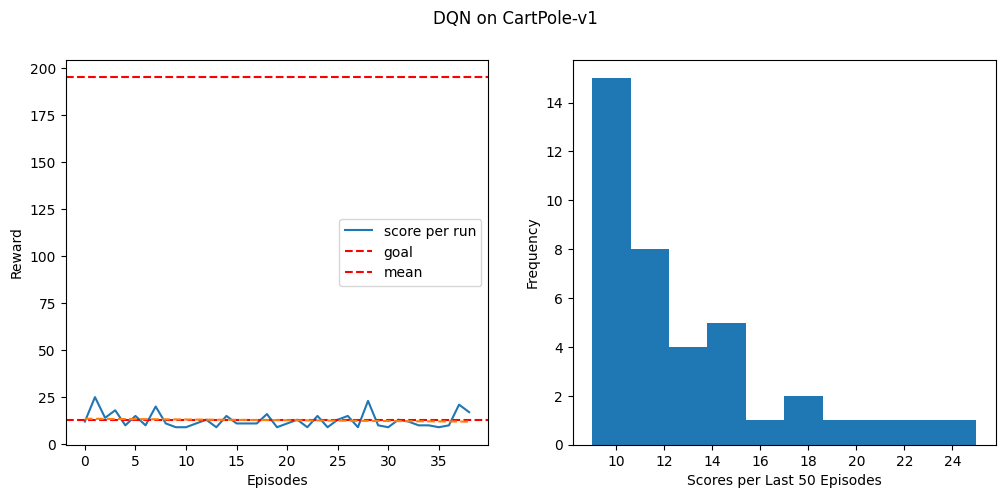

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x32 and 4x64)

In [6]:
class DDQN(DQN):
    def __init__(self):
        super().__init__()
        self.target = copy.deepcopy(self.model)

    def experience_replay(self):
        if len(self.memory) > MIN_MEMORY_FOR_EXPERIENCE_REPLAY:
            batch = random.sample(self.memory, EXPERIENCE_REPLAY_BATCH_SIZE)
            batch_t = list(map(list, zip(*batch)))  # Transpose batch list
            states = batch_t[0]
            actions = batch_t[1]
            next_states = batch_t[2]
            rewards = batch_t[3]
            is_dones = batch_t[4]

            states = torch.Tensor(np.array(states))
            actions_tensor = torch.Tensor(actions)
            next_states = torch.Tensor(np.array(next_states))
            rewards = torch.Tensor(rewards)
            is_dones_tensor = torch.Tensor(is_dones)

            is_dones_indices = torch.where(is_dones_tensor == True)[0]

            all_q_values = self.model(states)  # predicted q_values of all states
            all_q_values_next = self.model(next_states)
            online_net_selected_action = torch.max(all_q_values_next, axis=1).indices
            target_net_evaluated_q_value = self.target(next_states)[range(len(online_net_selected_action)),online_net_selected_action]
            # Update q values
            all_q_values[range(len(all_q_values)), actions] = rewards + \
                GAMMA*target_net_evaluated_q_value
            all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].numpy(
            ).astype(int)] = rewards[is_dones_indices.tolist()]
            self.update(states.tolist(), all_q_values.tolist())
            self.update_target_network()

    def update_target_network(self):
        self.target.load_state_dict(self.model.state_dict())

MAX_TRAINING_EPISODES = 200
agent = DDQN()
trial_episode_scores = []

for _ in range(MAX_TRAINING_EPISODES):
    state, info = env.reset(seed=1)
    episode_score = 0

    done = truncated = False
    while not (done or truncated):
        action = agent.act(state)
        next_state, reward, done, truncated, info= env.step(action)
        episode_score += reward
        agent.remember(state, action, reward, next_state, done|truncated)
        state = next_state
        agent.experience_replay()
    # agent.update_target_network()
    trial_episode_scores.append(episode_score)
    last_100_avg = np.mean(trial_episode_scores[-100:])
    # if len(trial_episode_scores) >= 100 and last_100_avg >= 195.0:
    #     break
    plot_res(trial_episode_scores, "DQN on CartPole-v1")